**Notebook Description:**

In this notebook we aim to measure the phenotypic strenth of the different kinase inhibitor treatments in our dataset. Similarly to Learning representations for image-based profiling of perturbations - Moskov et al. 2024 (https://www.nature.com/articles/s41467-024-45999-1#Sec2) we calculate the Eucliedean distance between control and treatment profiles (after batch correction via sphering transformation) represented by the CellProfiler features. This provides a "crude approximation of the average treatment effect" (Moskov et al.).

Use this measure we visualize the distribution of profiles in our data, and their relative strength of phenotypic effect compared to the DMSO negative control set. We then investigated how ATE impacted our model's ability to predict each inhibitor accurately.

In [1]:
import sys
import re
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sys.path.append("../")
from modules.zca import ZCA_corr, ZCA

# Load Data:

## Original Kinase Inhibitor Data:

In [3]:
ki_ibp = pd.read_csv('../data/ibp/ki_ibp.csv')
print(ki_ibp.shape)
ki_ibp.head(2)

(635, 4778)


,Metadata_Source,Metadata_Plate,Metadata_Well,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,Cells_AreaShape_BoundingBoxMinimum_Y,Cells_AreaShape_Center_X,...,smiles,clinical_phase,moa_src,Metadata_JCP2022,Metadata_InChIKey,Metadata_PlateType,blur_score,sat_score,focus_score,comp_score
0,source_3,JCPQC023,G14,3227.817708,5310.328125,589.21875,541.552083,519.484375,471.942708,553.446757,...,Nc1cc(c(cn1)-c1cc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...,Phase 3,dr_hub,JCP2022_013856,CWHUFRVAEUJCEF-UHFFFAOYSA-N,TARGET2,0.430742,0.453621,0.517562,1.401925
1,source_4,BR00121424,G14,4255.300000,7338.300000,572.70000,554.500000,488.420000,470.490000,530.260000,...,Nc1cc(c(cn1)-c1cc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...,Phase 3,dr_hub,JCP2022_013856,CWHUFRVAEUJCEF-UHFFFAOYSA-N,TARGET2,0.436727,0.144924,0.386009,0.967661


In [4]:
# Extract just the features:
ki_X = ki_ibp.select_dtypes(include=np.number).drop(["blur_score", "sat_score", "focus_score", "comp_score"], axis=1)

# List the feature and meta columns:
ki_feat_cols = ki_X.columns.tolist()
ki_meta_cols = ki_ibp.select_dtypes(exclude=np.number).columns.tolist()

# Calculate Euclidean Distance Between Profiles:

## Calculate median profile of control wells on plate:

In [5]:
# Load DMSO Control Data:
dmso_data = pd.read_csv('../data/dmso/dmso_ibp.csv', dtype={'Metadata_Plate': str})
print(dmso_data.shape)
dmso_data.head(2)

(12787, 4768)


,Metadata_Source,Metadata_Plate,Metadata_Well,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,Cells_AreaShape_BoundingBoxMinimum_Y,Cells_AreaShape_Center_X,...,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch,Metadata_Treatment,Metadata_JCP2022
0,source_3,JCPQC023,A05,4849.155133,9196.257034,574.657034,611.615970,480.688213,518.473004,527.243344,...,2.212169,2.203639,2.222221,2.232089,2.271333,2.225855,2.272496,CP_28_all_Phenix1,DMSO,JCP2022_033924
1,source_3,JCPQC023,A20,4719.449966,8844.685024,550.351914,623.965077,457.240430,532.879113,503.053976,...,1.589067,1.580273,1.591789,1.600087,1.635297,1.598422,1.633184,CP_28_all_Phenix1,DMSO,JCP2022_033924


**Note:**

The sphering code is obtained from the Scenario 4 settings at the following Github Repo:
https://github.com/carpenter-singh-lab/2023_Arevalo_BatchCorrection/blob/main/inputs/conf/scenario_4.json

In [6]:
# Define spherizer:
sphering_lambda = 0.01
spherizer = ZCA_corr(regularization=sphering_lambda)

In [ ]:
# Extract DMSO Feature Data:
dmso_X = dmso_data[ki_feat_cols]

# Fit the spherizer on the data:
spherizer.fit(dmso_X)

In [8]:
# Transform the DMSO data:
sph_dmso_X = spherizer.transform(dmso_X)

# Recreate dataframe with spherized features:
sph_feats = pd.DataFrame(sph_dmso_X, index=dmso_X.index, columns=ki_feat_cols)

# Re-combine with metadata:
# cols in metadata not in DMSO data:
exclude_cols = ['moa', 'target', 'smiles', 'clinical_phase', 'moa_src',
                'Metadata_InChIKey', 'Metadata_PlateType', 'Microscope']
include_meta = [item for item in ki_meta_cols if item not in exclude_cols]
dmso_sph = pd.concat([dmso_data[include_meta], sph_feats], axis=1)

In [9]:
# Calculate median DMSO profile across plates:
median_dmso_plate = dmso_sph.groupby('Metadata_Plate').agg(
                    lambda x: x.median() if x.dtype.kind in 'bif' else x.iloc[0]).reset_index(drop=False)

In [10]:
median_dmso_plate.head()

,Metadata_Plate,Metadata_Source,Metadata_Well,Metadata_Batch,Metadata_JCP2022,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,1053597936,source_2,A05,20210712_Batch_5,JCP2022_033924,0.261094,-1.941988,-0.382351,-0.037488,-0.058130,...,0.024521,-0.069950,0.025408,0.031764,0.017053,0.030085,0.029825,0.034564,0.021325,0.024664
1,1086289792,source_2,A02,20211003_Batch_13,JCP2022_033924,0.231293,-1.534895,-0.350844,-0.219038,-0.052848,...,-0.206919,-0.204561,-0.159306,-0.162388,-0.172119,-0.152556,-0.159182,-0.183998,-0.174716,-0.188123
2,1086291917,source_2,A02,20210823_Batch_10,JCP2022_033924,0.152655,-1.695720,-0.306716,-0.116728,0.020888,...,0.061100,-0.035477,0.039627,0.046660,0.034233,0.045398,0.043225,0.054785,0.042923,0.040832
3,1086291924,source_2,A02,20210823_Batch_10,JCP2022_033924,0.135010,-1.727233,-0.399871,-0.180048,-0.027726,...,0.059413,-0.021427,0.068077,0.077671,0.065706,0.080976,0.077039,0.070853,0.066439,0.064631
4,1086291931,source_2,A02,20210823_Batch_10,JCP2022_033924,0.202989,-1.601119,-0.323737,-0.114773,-0.030947,...,0.053705,-0.027278,0.064793,0.075934,0.060763,0.077877,0.075802,0.069355,0.070075,0.064201


## Apply Spherizer to Kinase Inhibitor Compound Data:

In [11]:
# Transform the ki feature data with the spherizer fit on the control data:
ki_sph_X = spherizer.transform(ki_X)

In [12]:
# Recreate dataframe with spherized features:
sph_ki_df = pd.DataFrame(ki_sph_X, index=ki_X.index, columns=ki_feat_cols)

# Re-combine with metadata:
ki_sph = pd.concat([ki_ibp[ki_meta_cols], sph_ki_df], axis=1)

In [13]:
ki_sph.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,moa,target,smiles,clinical_phase,moa_src,Metadata_JCP2022,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_3,JCPQC023,G14,CP_28_all_Phenix1,PI3K,PIK3CA|PIK3CG,Nc1cc(c(cn1)-c1cc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...,Phase 3,dr_hub,JCP2022_013856,...,0.255575,0.489330,0.321870,0.300815,0.338343,0.327132,0.269517,0.132219,0.323733,0.244790
1,source_4,BR00121424,G14,2021_06_21_Batch7,PI3K,PIK3CA|PIK3CG,Nc1cc(c(cn1)-c1cc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...,Phase 3,dr_hub,JCP2022_013856,...,0.649852,-0.242832,-0.187316,-0.057702,-0.224317,0.081250,0.140673,0.193516,0.096504,0.394253
2,source_9,GR00003340,D35,20210901_Run8,PI3K,PIK3CA|PIK3CG,Nc1cc(c(cn1)-c1cc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...,Phase 3,dr_hub,JCP2022_013856,...,-0.278445,-0.301541,-0.289879,-0.263609,-0.276633,-0.266093,-0.271123,-0.251415,-0.256114,-0.248847
3,source_4,BR00121423,G14,2021_08_02_Batch10,PI3K,PIK3CA|PIK3CG,Nc1cc(c(cn1)-c1cc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...,Phase 3,dr_hub,JCP2022_013856,...,0.179270,0.886022,0.063666,-0.014352,0.017277,0.062136,0.052690,-0.122700,-0.013990,0.048778
4,source_9,GR00003300,T11,20210914-Run9,PI3K,PIK3CA|PIK3CG,Nc1cc(c(cn1)-c1cc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...,Phase 3,dr_hub,JCP2022_013856,...,-0.192850,-0.309670,-0.225077,-0.223719,-0.249177,-0.206815,-0.204320,-0.218457,-0.229162,-0.197685


## Estimate Distribution of Control Well Distances to Median Control Profile per Plate and Calculate Their Mean and Std:

In [14]:
def euclidean_distance(arr1, arr2):
  """
  This function calculates the Euclidean distance between two NumPy arrays.
  """
  return np.linalg.norm(arr1 - arr2)

In [15]:
ctrl_means = []
ctrl_stds = []

for p in range(len(median_dmso_plate)):
    # Return each unique plate:
    meta_plate = median_dmso_plate["Metadata_Plate"][p]
    
    # Return the spherized median control well data for that Plate:
    med_ctrl = median_dmso_plate[median_dmso_plate["Metadata_Plate"]==meta_plate][ki_feat_cols].values
    
    # Return all control profiles on that plate from the DMSO data:
    plate_dmso = dmso_sph[dmso_sph["Metadata_Plate"]==meta_plate].reset_index(drop=True)
    
    plate_distances = []
    # Calculate the Euclidean distances between each control and the median control on that plate:
    for i in range(len(plate_dmso)):
        dmso_well = plate_dmso.iloc[i][ki_feat_cols].values
        distance = euclidean_distance(dmso_well, med_ctrl)
        plate_distances.append(distance)
        
    # Calculate the mean and std of these distances and append outside loop:
    ctrl_means.append(np.mean(plate_distances))
    ctrl_stds.append(np.std(plate_distances))


In [16]:
# Assign statistics to column in median plate DMSO dataframe:
median_dmso_plate['ctrl_mean'] = ctrl_means
median_dmso_plate['ctrl_std'] = ctrl_stds

## Euclidean Distance Between Treated Well and Median Control Profile on that Plate:

In [17]:
z_scores = []

for i in range(len(ki_sph)):
    # Return the treatment well details for each row of data:
    treated_well = ki_sph.iloc[i][ki_feat_cols].values
    well_plate = ki_sph["Metadata_Plate"][i]
    
    # Return stats and profile of the spherized median DMSO data for that Plate:
    control_data = median_dmso_plate[median_dmso_plate["Metadata_Plate"]==well_plate]
    med_ctrl_feats = control_data[ki_feat_cols].values
    
    # Return the mean and std of control profile distances from the median control on that plate:
    med_ctrl_mean = control_data['ctrl_mean'].values
    med_ctrl_std = control_data['ctrl_std'].values
    
    # Calculate Euclidean distance between the treated well and the median DMSO control for that plate:
    distance = euclidean_distance(treated_well, med_ctrl)
    
    # Calculate z-score using the control well statistics:
    z_score = (distance - med_ctrl_mean) / med_ctrl_std
    z_scores.append(z_score[0])

## Calculate Average Z-score Across Replicates and Plot:

In [19]:
# Assign z-scores to spherized data:
ki_sph['z_score'] = z_scores

In [20]:
# Group data by replicate - Calculate mean profile:
mean_sph_ki = ki_sph.groupby('Metadata_JCP2022').agg(
                    lambda x: x.mean() if x.dtype.kind in 'bif' else x.iloc[0]).reset_index(drop=False)

In [21]:
# Sort 'z_score' column in ascending order
mean_sph_ki_sorted = mean_sph_ki.sort_values(by='z_score').reset_index(drop=True)

# Calculate percentiles for bands in plot:
percentiles = [0.2, 0.4, 0.6, 0.8]  # Define percentiles for each band (20%, 50%, 80%)
thresholds = mean_sph_ki_sorted['z_score'].quantile(percentiles).to_list()
direction = ["lower", "higher", "lower", "higher"]

In [22]:
mean_sph_ki_sorted.index[-1]

95

In [23]:
thresholds

[31.018011043610205,
 40.279185057795246,
 47.339147457877765,
 57.587797882111474]

In [24]:
z_score_plot_idx = []

# Return the index of z_score values to cut thresholds at:
for i, (d, t) in enumerate(zip(direction, thresholds)):
    if d == "lower":
        plot_idx = mean_sph_ki_sorted[mean_sph_ki_sorted['z_score'] <= t].index[-1]
    else: # Return first index if over 40% or 80% threshold
        plot_idx = mean_sph_ki_sorted[mean_sph_ki_sorted['z_score'] > t].index[0]
    z_score_plot_idx.append(plot_idx)

z_score_plot_idx

[19, 39, 57, 77]

C:\Users\rozhouse\AppData\Local\Temp\ipykernel_63856\4127553276.py:27: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, np.exp(max_log_z_score))


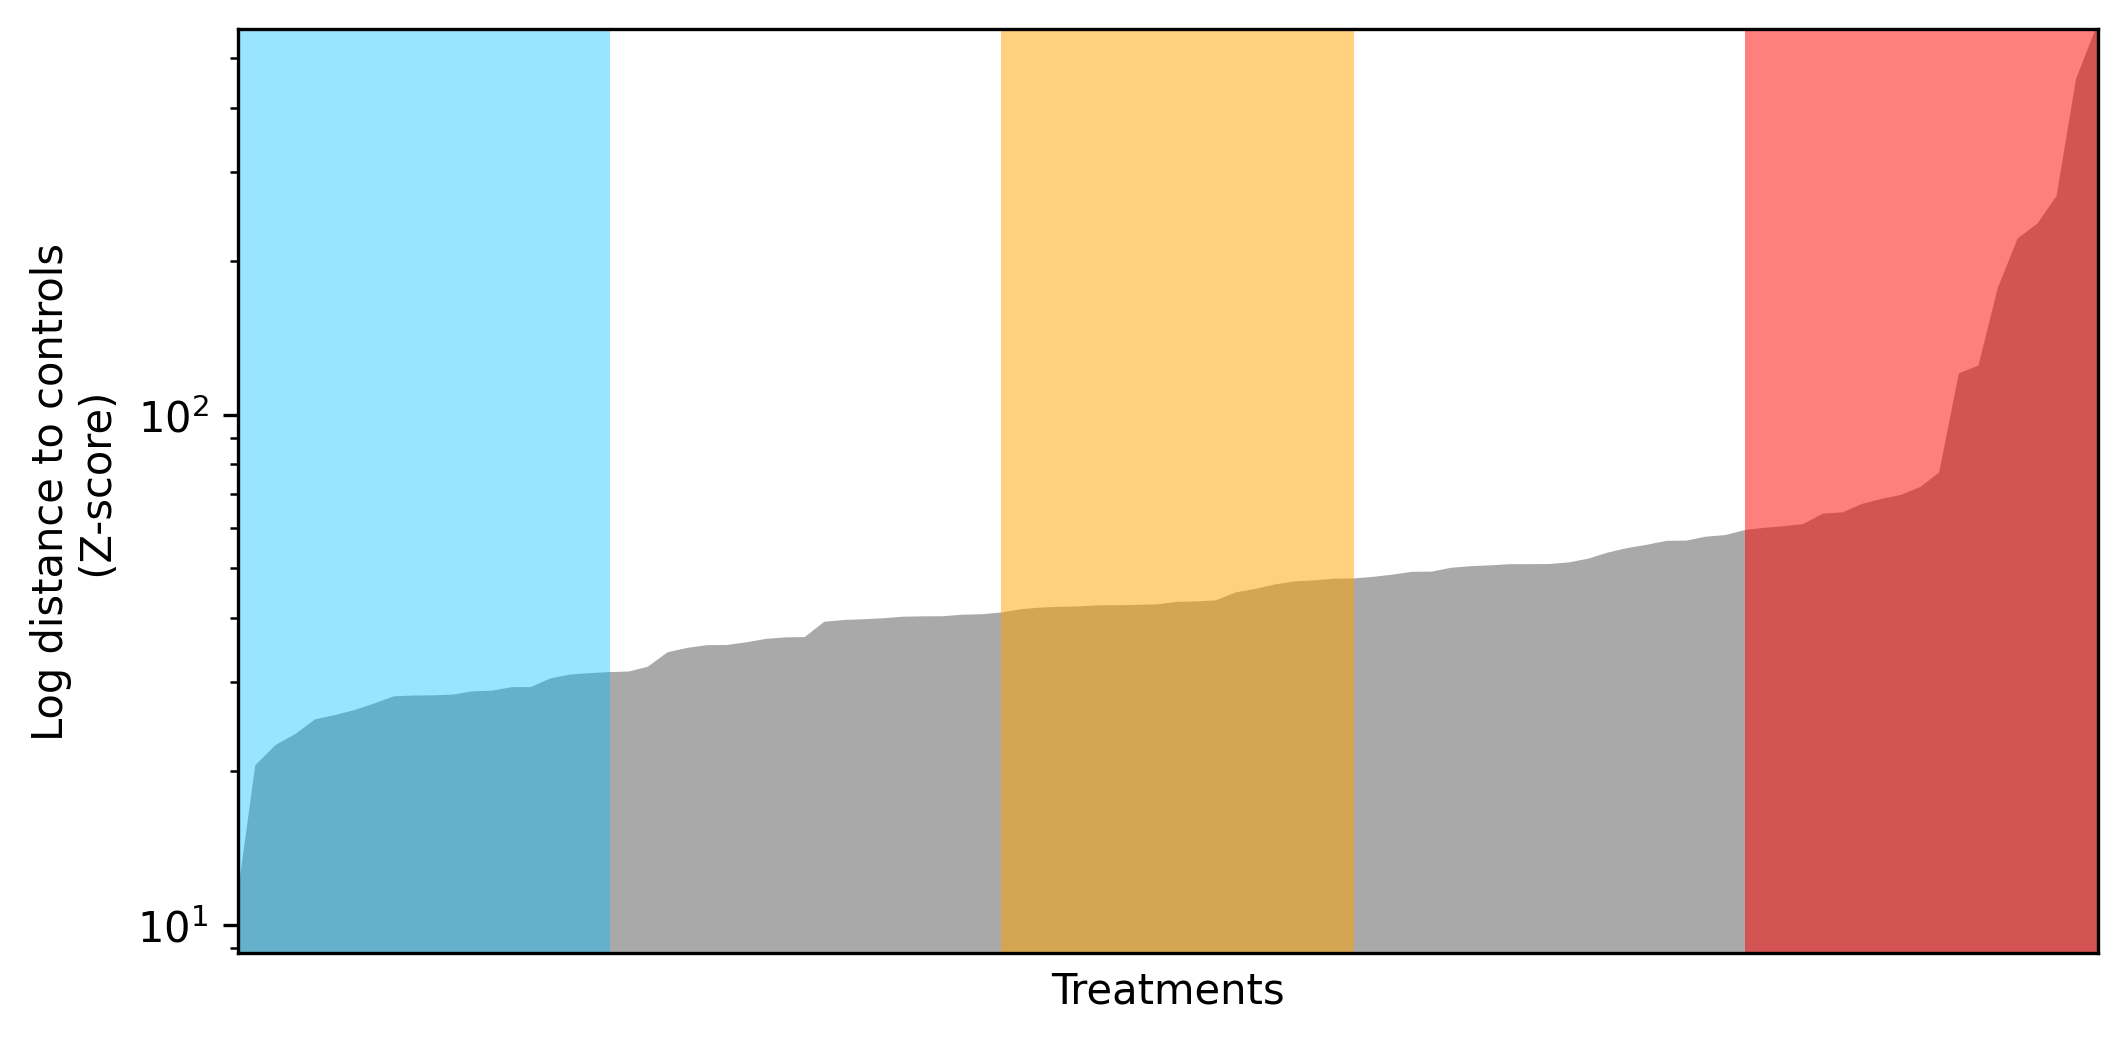

In [39]:
# Create filled line plot of z-scores:
plt.figure(figsize=(8, 4), dpi=300)
plt.plot(mean_sph_ki_sorted.index, mean_sph_ki_sorted['z_score'], 
             marker='none', linestyle='none', color="darkgrey")
# Fill under line with grey:
plt.fill_between(mean_sph_ki_sorted.index, mean_sph_ki_sorted['z_score'], color="darkgrey")

# Fill between thresholds with different colors:
z_scores_y = mean_sph_ki_sorted['z_score'].to_list()
z_scores_y.insert(0, 0)

plt.fill_betweenx(z_scores_y, 0, z_score_plot_idx[0], 
                  color='deepskyblue', edgecolor="none", alpha=0.4)
plt.fill_betweenx(z_scores_y, z_score_plot_idx[1], z_score_plot_idx[2], 
                  color='orange', edgecolor="none", alpha=0.5)
plt.fill_betweenx(z_scores_y, z_score_plot_idx[3], mean_sph_ki_sorted.index[-1], 
                  color='red', edgecolor="none", alpha=0.5)
        
# Annotation:
plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Treatments')
plt.ylabel('Log distance to controls\n (Z-score)')
plt.xticks([])

# Set axis limits:
max_log_z_score = np.log(np.max(mean_sph_ki_sorted['z_score']))
plt.ylim(0, np.exp(max_log_z_score))
plt.xlim(0, mean_sph_ki_sorted.index[-1])

plt.savefig("../media/ATE/ATE_To_Controls.png")
plt.show()

# Showing Average Treatment Effect Strength by MOA:

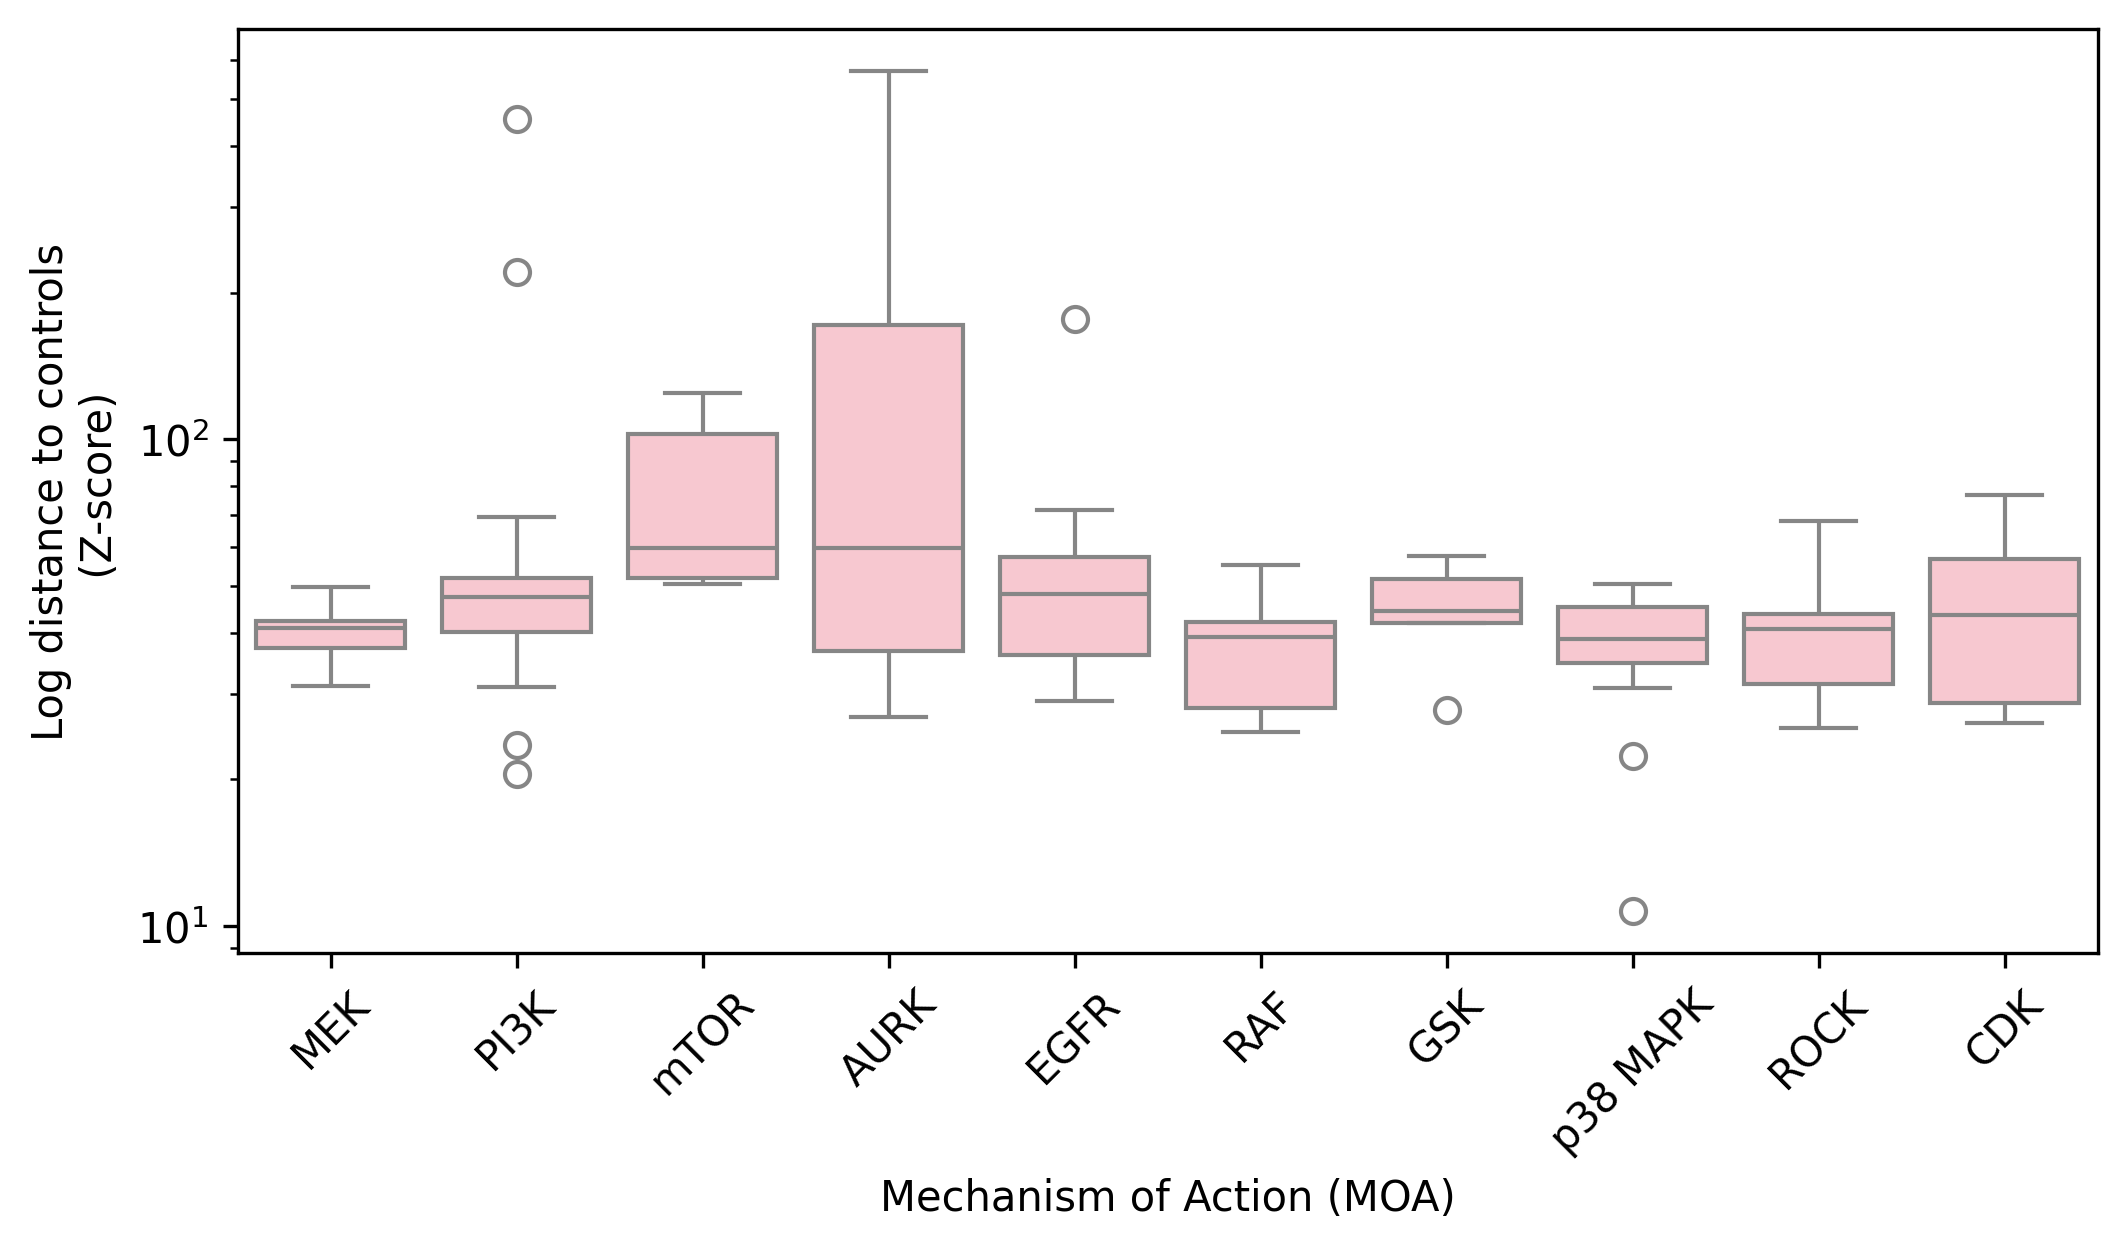

In [26]:
plt.figure(figsize=(8, 4), dpi=300)

sns.boxplot(
    x = "moa",
    y = "z_score",
#     showmeans=True,  # Show mean as a point within each box
    data=mean_sph_ki,
    color="pink", 
    log_scale=True,
)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees

# Customize the plot
plt.xlabel("Mechanism of Action (MOA)")
plt.ylabel('Log distance to controls\n (Z-score)')
plt.savefig("../media/ATE/ATE_KI_Classes.png")

plt.show()

# ATE Impact on Predictive Performance:

## Label Datapoints into ATE Categories:

In [27]:
def categorize_z_score(z_score):
    # Thresholds obtained above
    thresholds = [31.018011043610205, 40.279185057795246, 47.339147457877765, 57.587797882111474]
    if z_score <= thresholds[0]:
        return 'weak'
    elif (z_score > thresholds[1]) and (z_score <= thresholds[2]):
        return 'medium'
    elif z_score > thresholds[3]:
        return 'strong'
    else:
        return 'no_cat'

In [28]:
mean_sph_ki['thresh_cat'] = mean_sph_ki['z_score'].apply(categorize_z_score)

## Return Model Predictions and Add to Dataframe:

In [29]:
def string_to_float_list(s, method='new'):
    if method == 'old':
        s = s.replace('[', '').replace('[', '').replace('\n', '')
        s = re.sub(r'\s+', ', ', re.sub(r'\s*\]', '', s))
#         print("STRING", s)
    return [float(val) for val in s.split(',')]

In [30]:
def return_preds(pred_dir, method, cv_folds=5):
    """
    Returns the five compound prediction dataframes associated with the cross-val test datasets for the specified model.
    method: the method of storing proba data changed, so this reflects how it was stored when each model was run, don't change below
    """
    cpnd_frames = []

    for i in range(cv_folds):
        cpnd_file = glob.glob(f'{pred_dir}/CV{i}_eval/cpnd*.csv')
        cdf = pd.read_csv(cpnd_file[0])
        cpnd_frames.append(cdf)

    # Create combined dataframes of predictions across folds:
    cpnd_comb = pd.concat(cpnd_frames, axis=0).reset_index(drop=True)
    cpnd_comb['proba'] = cpnd_comb['proba'].apply(string_to_float_list, method=method)
    
    # Create a column signifying a correct prediction (1=correct):
    cpnd_comb['correct'] = cpnd_comb['preds'] == cpnd_comb['actuals']
    cpnd_comb['correct'] = cpnd_comb['correct'].astype(int)
    
    # Create dictionary mapping compound ID to accuracy of prediction:
    acc_dict = dict(zip(cpnd_comb['cpnd_ids'], cpnd_comb['correct']))
    
    return acc_dict

In [31]:
cvf_fusion = '../results/fusion/model_eval/'  # CVF model results
fuse_dict = return_preds(cvf_fusion, method='old')
mean_sph_ki["fusion_acc"] = [fuse_dict[x] for x in mean_sph_ki.Metadata_InChIKey.tolist()]

In [32]:
mean_sph_ki

,Metadata_JCP2022,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,moa,target,smiles,clinical_phase,moa_src,...,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,z_score,thresh_cat,fusion_acc
0,JCP2022_000568,source_3,BR5876c3,E13,CP60,MEK,MAP2K1|MAP2K2,Cn1cnc2c(F)c(Nc3ccc(Br)cc3F)c(cc12)C(=O)NOCCO,Launched,dr_hub,...,0.593433,0.687927,0.597442,0.581195,0.508979,0.561888,0.460324,31.099348,no_cat,1
1,JCP2022_000641,source_2,1086292457,O04,20210816_Batch_9,PI3K,Not listed,Nc1cc(c(cn1)-c1nc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...,Phase 2,dr_hub,...,0.164940,0.202376,0.149464,0.124803,0.096386,0.147804,0.085030,63.460110,strong,1
2,JCP2022_001937,source_7,CP3-SC1-19,A17,20210727_Run3,mTOR,MTOR,CCC(=O)N1CCN(CC1)c1ccc(cc1C(F)(F)F)-n1c2c(ccc1...,Preclinical,dr_hub,...,0.201882,0.206531,0.178796,0.190805,0.082521,0.174254,0.079267,63.808400,strong,1
3,JCP2022_002057,source_3,BR5871c3,O22,CP59,AURK,AURKA,CCN1CCN(CC1)C(=O)Cc1ccc(Nc2ncc(F)c(Nc3ccc(cc3)...,Preclinical,dr_hub,...,10.405358,10.318030,10.712836,10.696009,11.301844,10.530514,8.898938,267.728129,strong,1
4,JCP2022_002910,source_3,BAY5873c,L16,CP_36_all_Phenix1,EGFR,EGFR,CN1CCN(CC1)c1ccc(Nc2ncc(Cl)c(Oc3cccc(NC(=O)C=C...,Preclinical,dr_hub,...,2.850234,2.287981,2.940532,3.524299,3.681578,2.303208,3.357812,176.910643,strong,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,JCP2022_111823,source_3,BR5876c3,D12,CP60,RAF,BRAF|KDR,CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(Cl)cc...,Preclinical,dr_hub,...,0.586652,0.569624,0.581102,0.603384,0.541613,0.575865,0.566817,28.019008,weak,0
92,JCP2022_112149,source_6,110000295609,A08,p211012CPU2OS48hw384exp033JUMP,ROCK,PKIA|PRKACA|ROCK1,O=c1[nH]ccc2c(cccc12)S(=O)(=O)N1CCCNCC1,Preclinical,dr_hub,...,0.112252,0.126407,0.107686,0.106877,0.070240,0.107157,0.089023,41.506068,medium,1
93,JCP2022_112951,source_7,CP3-SC1-13,D03,20210727_Run3,AURK,AURKB|INCENP|MAP2K1,C1CCC(CC1)Nc1nc(Nc2ccc(cc2)N2CCOCC2)nc2nc[nH]c12,Preclinical,dr_hub,...,0.005525,-0.013302,0.024795,0.008734,0.027005,0.023035,0.071353,59.502052,strong,1
94,JCP2022_113064,source_3,BR5873c3,M04,CP60,RAF,BRAF|RAF1,Cc1ccc(NC(=O)c2cccc(c2)C(C)(C)C#N)cc1Nc1ccc2nc...,Preclinical,dr_hub,...,1.064566,1.167034,1.082658,0.973211,1.014519,0.946858,0.808385,41.184928,medium,1


In [33]:
acc_cat_df = mean_sph_ki[["z_score", "thresh_cat", "fusion_acc"]].groupby('thresh_cat').agg(
                                                                    lambda x: x.mean()).reset_index(drop=False)
# Drop datapoints which don't fall into a category (no_cat):
acc_cat_df = acc_cat_df.drop(1)
acc_cat_df

,thresh_cat,z_score,fusion_acc
0,medium,43.521865,0.684211
2,strong,151.985462,0.842105
3,weak,26.504558,0.650000


## Plot results:

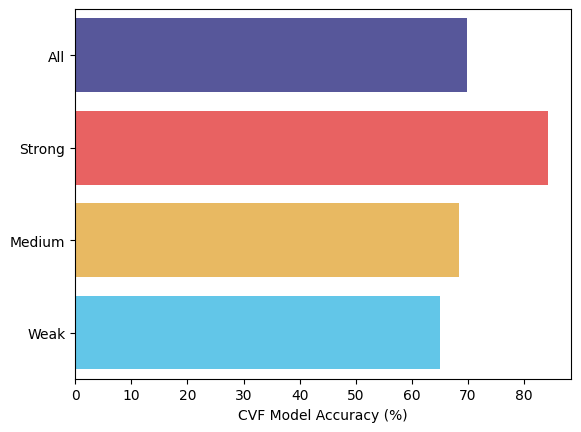

In [40]:
sns.barplot(
    # Values from dataframe above:
    x = [69.79, 84.2105,68.4211, 65] ,
    y = ["All", "Strong", "Medium", "Weak"],  
    hue = ["All", "Strong", "Medium", "Weak"],
    palette = ['navy', 'red', 'orange', 'deepskyblue'],
    alpha = 0.7,
)

plt.ylabel("")
# plt.yticks("")
plt.xlabel("CVF Model Accuracy (%)")
plt.savefig("../media/ATE/ATE_ModelAcc.png")

plt.show()